# Part ① Exploratory data analysis

## Table of contents
- <a href="#C0">0. Importing libraries </a>
- <a href="#C1">1. Combining 2015 and 2016 data</a>
- <a href="#C2">2. Cleaning data</a>
    - <a href="#C2.1">2.1 Duplicates</a>
    - <a href="#C2.2">2.2 Features selection</a>
    - <a href="#C2.3">2.3 Targets: Energy and Emissions</a>
    - <a href="#C2.4">2.4 Location features</a>
    - <a href="#C2.5">2.5 Building type features</a>
    - <a href="#C2.6">2.6 Building size features</a>
    - <a href="#C2.7">2.7 Construction date</a>
    - <a href="#C2.8">2.8 Energy star score</a>
    - <a href="#C2.9">2.9 Verifying columns types and missing values</a>
- <a href="#C3">3. Exploratory data analysis</a>
    - <a href="#C3.1">3.1 Univariate analysis</a>
    - <a href="#C3.2">3.2 Multivariate analysis</a>
- <a href="#C4">4. Exporting cleaned data</a>

# <a name="C0">0. Importing libraries </a>

In [776]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from ast import literal_eval

import matplotlib.image as mpimg
import plotly.graph_objects as go
import plotly.express as px
import geopandas as gpd
import os
if not os.path.exists("images"):
    os.mkdir("images")

from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import dataframe_image as dfi

In [649]:
pd.set_option('display.max_columns', None) # to show all columns
# pd.reset_option(“max_columns”) # to go back to default columns display
pd.set_option('display.max_rows', None) # to show all rows
# pd.reset_option(“max_rows”) # to go back to default columns display
sns.set_style("white")

# <a name="C1">1. Combining 2015 and 2016 data</a>

<div class="alert alert-block alert-warning">
<b>Objective</b>
<hr>
Data was collected for two different years: 2015 and 2016.<br>
A comparison is made between the two, in order to combine both datasets.
    
</div>

## 1.1 Importing data

In [650]:
df15 = pd.read_csv('2015.csv') #, sep='\t'
df16 = pd.read_csv('2016.csv')

In [651]:
df15.shape

(3340, 47)

In [652]:
df16.shape

(3376, 46)

## 1.2 Visualizing missing data

In [653]:
# Renaming longest attribute for clarity
df15 = df15.rename(columns = {'Seattle Police Department Micro Community Policing Plan Areas': 'SPD_Areas'
                                  },
                                  inplace = False)


In [654]:
def barplot_missing(df, year):
    # Calculation of missing data proportion for each feature
    actually_filled = 1-df.isna().mean().sort_values() # 1 minus NaN proportion
    half_len = round(len(actually_filled)/2)
    half_data = (actually_filled.iloc[:half_len],actually_filled.iloc[half_len:])
    
    fig, axis = plt.subplots(1, 2, figsize=(15, 10))
    
    for idx, (ax, be) in enumerate(zip(axis, half_data)):

        ax = sns.barplot(y=be.index,
                         x=be.values, ax=ax, color='#7B2E3E') #5E86D8
        
        container = ax.containers[0]
        ax.bar_label(container,
                     labels=[f'{x:.2f}' for x in container.datavalues],
                     fontsize=15)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.xaxis.tick_top()
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(15)

    fig.suptitle('Proportion of filled data for the year {}'.format(str(year)), fontsize=25, y=1.0)
    fig.tight_layout()
    plt.savefig(f'proportion_{year}.png', transparent=True, bbox_inches='tight')
    
    return plt.show()

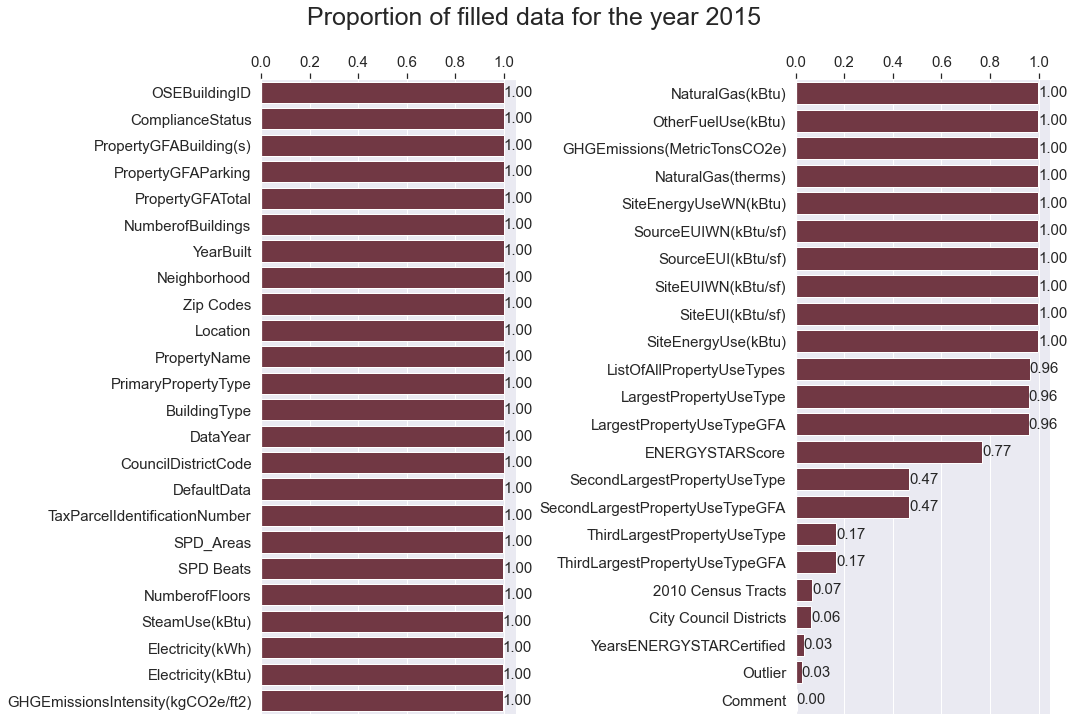

In [655]:
barplot_missing(df15, 2015)

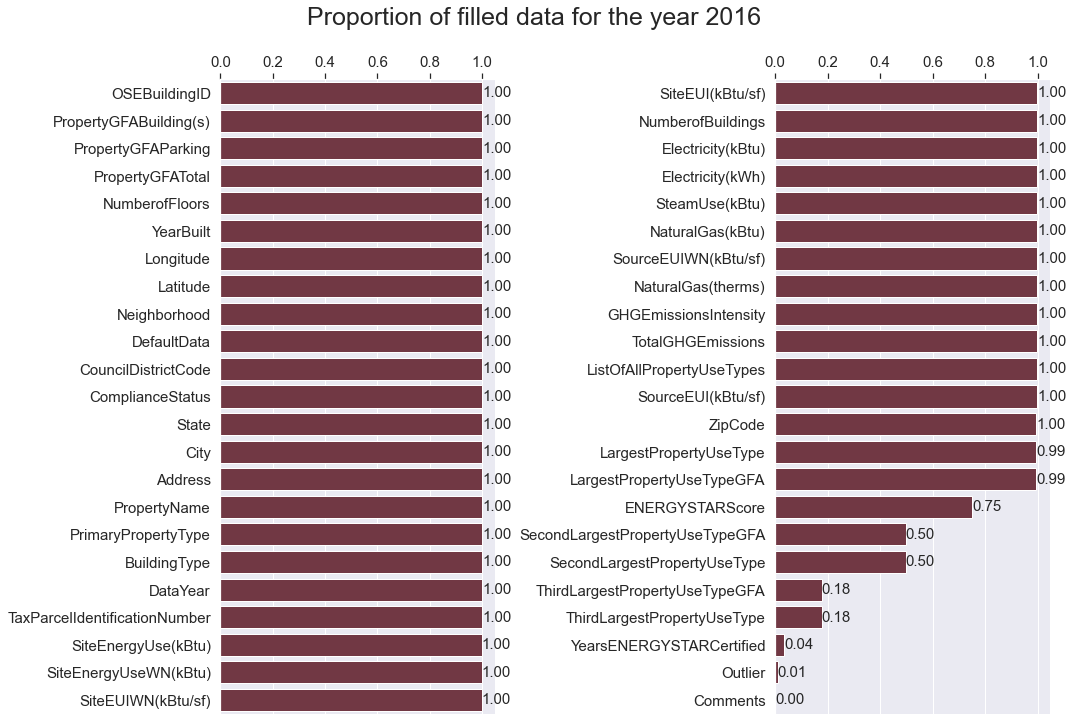

In [656]:
barplot_missing(df16, 2016)

<div class="alert alert-block alert-info">

Both 2015 and 2016 data are very well filled. Most columns are close to 100% filled data.
    
</div>

## 1.3 Difference between 2015 and 2016 variables

In [657]:
# unique to 2015
diff = [i for i in df15 if i not in df16]
diff

['Location',
 'OtherFuelUse(kBtu)',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Comment',
 '2010 Census Tracts',
 'SPD_Areas',
 'City Council Districts',
 'SPD Beats',
 'Zip Codes']

In [658]:
# unique to 2016
diff2 = [i for i in df16 if i not in df15]
diff2

['Address',
 'City',
 'State',
 'ZipCode',
 'Latitude',
 'Longitude',
 'Comments',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity']

In [659]:
common_id = len([i for i in df15["OSEBuildingID"] if i in df16["OSEBuildingID"].values])

print('There are {} common buildings between 2015 and 2016'.format(common_id))

There are 3284 common buildings between 2015 and 2016


In [660]:
added_id = df15.shape[0] - common_id
print('There were {} new buildings that were added in 2016'.format(added_id))

There were 56 new buildings that were added in 2016


In [661]:
missing_id = df16.shape[0] - common_id
print('There were {} buildings present in 2015 but missing in 2016'.format(missing_id))

There were 92 buildings present in 2015 but missing in 2016


<div class="alert alert-block alert-info">

Data from 2016 will be considered, as it is more recent and difference in terms of buildings ID with 2015 is not significant.<br>
Buildings of 2015 that are not in 2016 will be added to it, and NaN of 2016 will be completed by 2015 where applicable.<br>
As 2015 data contains different column names, they are first uniformized based on 2016 content.
    
</div>

In [662]:
# Renaming some columns of 2015 so that they're the same as 2016
df15_tidy = df15.rename(columns = {'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions',
                                   'GHGEmissionsIntensity(kgCO2e/ft2)':'GHGEmissionsIntensity',
                                   'Comment':'Comments'
                                  },
                                  inplace = False)


In [663]:
# Extracting latitude and longitude from 'Location'
df15_tidy["Location"] = df15_tidy["Location"].apply(literal_eval)
df15_tidy["Latitude"] = df15_tidy["Location"].apply(lambda x: x["latitude"]).astype('float64')
df15_tidy["Longitude"] = df15_tidy["Location"].apply(lambda x: x["longitude"]).astype('float64')

In [664]:
df15_tidy['Latitude'][0]

47.61219025

In [665]:
# Removing useless variables of 2015
df15_tidy.drop([ 'Location',  'OtherFuelUse(kBtu)',  '2010 Census Tracts', 'SPD_Areas',
                 'City Council Districts', 'SPD Beats', 'Zip Codes'
               ], axis=1, inplace=True)

## 1.4 Combining 2015 and 2016 data

In [666]:
# Completing 2016 information with 2015
df0 = df16.combine_first(df15_tidy)

# <a name="C2">2. Cleaning data</a>

## <a name="C2.1">2.1 Duplicates</a>

In [667]:
# Count missing building ID
missing_id = df0['OSEBuildingID'].isna().sum().sum()
missing_id

0

In [668]:
# Check for duplicates
df0.duplicated('OSEBuildingID').sum()

0

<div class="alert alert-block alert-info">

There are no building ID duplicates.
    
</div>

 ## <a name="C2.2">2.2 Features selection</a>

<div class="alert alert-block alert-warning">
<b>Objective</b>
<hr>
The purpose is to calculate total energy, and total CO2 emissions, based solely on declarative commercial data.<br>
Understanding of features comes from Seattle website.<br>
    
[Source data.seattle.gov](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy)
</div>

<div class="alert alert-block alert-info">

Features can be grouped in 4 categories:
    
|General information|Location|Energies|Type and size|
|:---:|:---:|:---:|:---:|
|OSEBuildingID|Address|YearsENERGYSTARCertified|BuildingType|
|PropertyName|City|ENERGYSTARScore|PrimaryPropertyType|
|TaxParcelIdentificationNumber|State|SiteEUI(kBtu/sf)|YearBuilt|
|DataYear|ZipCode|SiteEUIWN(kBtu/sf)|NumberofBuildings|
|DefaultData|CouncilDistrictCode|SourceEUI(kBtu/sf)|NumberofFloors|
|Comments|Neighborhood|SourceEUIWN(kBtu/sf)|PropertyGFATotal|
|ComplianceStatus|Latitude|SiteEnergyUse(kBtu)|PropertyGFAParking|
|Outlier|Longitude|SiteEnergyUseWN(kBtu)|PropertyGFABuilding(s)|
|||SteamUse(kBtu)|ListOfAllPropertyUseTypes|
|||Electricity(kWh)|LargestPropertyUseType|
|||Electricity(kBtu)|SecondLargestPropertyUseType|
|||NaturalGas(therms)|ThirdLargestPropertyUseType|
|||NaturalGas(kBtu)|LargestPropertyUseTypeGFA|
|||TotalGHGEmissions|SecondLargestPropertyUseTypeGFA|
|||GHGEmissionsIntensity|ThirdLargestPropertyUseTypeGFA|
    
</div>

<div class="alert alert-block alert-info">

**General information**: only the building ID is of importance.<br><br>
**Location**: city and state are all the same, and address has no purpose.<br><br>
**Energy related features** can't be considered in ML models, as we are trying to predict the total energy consumption.<br>
Therefore in Energies category, only targets and energystar are kept. <br>
<br>
<ins>**Target variables**</ins><br><br>
    <li>Total energy is given by the variable 'SiteEnergyUse(kBtu)' -> will be renamed **'Energy'**</li>
    <li>Total CO2 emission is given by the variable 'TotalGHGEmissions' -> will be renamed **'Emissions'**</li><br>

**Variables with more than 50% missing values** are also not selected. For the most part they're describing secondary usage of buildings.<br>
<br>
'PropertyGFABuilding(s)' will be renamed 'PropertyGFABuilding'
<br><br>
    
<ins>**Selected features**</ins><br><br>
    
|General information|Location|Energies|Type|Size|
|:---:|:---:|:---:|:---:|:---:|
|OSEBuildingID|CouncilDistrictCode|ENERGYSTARScore|BuildingType|NumberofBuildings|
||Neighborhood|Energy|PrimaryPropertyType|NumberofFloors|
||ZipCode|Emissions|YearBuilt|PropertyGFATotal|
||Latitude||ListOfAllPropertyUseTypes|PropertyGFAParking|
||Longitude||LargestPropertyUseType|PropertyGFABuilding|
    
</div>

In [669]:
# Renaming features
df0= df0.rename(columns = {'SiteEnergyUse(kBtu)': 'Energy',
                           'TotalGHGEmissions': 'Emissions',
                           'PropertyGFABuilding(s)':'PropertyGFABuilding'}, inplace = False)

In [670]:
# Selecting relevant features
df = df0[['OSEBuildingID','BuildingType','PrimaryPropertyType',
          'ListOfAllPropertyUseTypes','LargestPropertyUseType',
         'CouncilDistrictCode','Neighborhood','ZipCode','Latitude','Longitude',
         'YearBuilt','NumberofBuildings','NumberofFloors','PropertyGFATotal',
         'PropertyGFABuilding','PropertyGFAParking',
          'ENERGYSTARScore','Energy','Emissions']]

In [671]:
df.describe()

,OSEBuildingID,CouncilDistrictCode,ZipCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFABuilding,PropertyGFAParking,ENERGYSTARScore,Energy,Emissions
count,3376.000000,3376.000000,3360.000000,3376.000000,3376.000000,3376.000000,3376.000000,3376.000000,3.376000e+03,3.376000e+03,3376.000000,3133.000000,3.376000e+03,3375.000000
mean,21208.991114,4.439277,98116.949107,47.624033,-122.334795,1968.573164,1.106635,4.709123,9.483354e+04,8.683201e+04,8001.526066,67.970954,5.409555e+06,119.598767
std,12223.757015,2.120625,18.615205,0.047758,0.027203,33.088156,2.105908,5.494465,2.188376e+05,2.079398e+05,32326.723928,26.992918,2.160419e+07,538.215926
min,1.000000,1.000000,98006.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,3.636000e+03,0.000000,1.000000,0.000000e+00,-0.800000
25%,19990.750000,3.000000,98105.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,2.775600e+04,0.000000,53.000000,9.252110e+05,9.495000
50%,23112.000000,4.000000,98115.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,4.321600e+04,0.000000,75.000000,1.803279e+06,33.920000
75%,25994.250000,7.000000,98122.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,8.427625e+04,0.000000,90.000000,4.221247e+06,93.940000
max,50226.000000,7.000000,98272.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,9.320156e+06,512608.000000,100.000000,8.739237e+08,16870.980000


## <a name="C2.3">2.3 Targets: Energy and Emissions</a>

In [672]:
# Negative and null values are removed
for i in ['Energy', 'Emissions']:
    df = df[df[i]>0]

In [673]:
df.shape

(3354, 19)

## <a name="C2.4">2.4 Location features</a>

In [674]:
def seattle_map(feature):
    fig = px.scatter_mapbox(df,
                            lat='Latitude',
                            lon='Longitude',
                            color=feature,
                            size_max=10,
                            zoom=10,
                            mapbox_style='carto-positron')
    fig.update_layout(
        width=600,
        height=600,
        margin={"l": 0, "r": 0, "t": 0, "b": 0},
#         title = f'Visualization of {feature} on Seattle map'
    )
    fig.write_image(f'Vizualisation_of_{feature}_on_seattle_map.png')
    fig.show()

### 2.4.1 CouncilDistrictCode

In [675]:
df['CouncilDistrictCode'].value_counts()

7    1032
3     590
2     508
4     366
5     334
1     280
6     244
Name: CouncilDistrictCode, dtype: int64

In [676]:
df['CouncilDistrictCode'] = df['CouncilDistrictCode'].astype(object)

In [677]:
seattle_map('CouncilDistrictCode')

### 2.4.2 Neighborhood

In [678]:
df['Neighborhood'].value_counts().count()

19

In [679]:
df['Neighborhood'].value_counts()

DOWNTOWN                  571
EAST                      452
MAGNOLIA / QUEEN ANNE     420
GREATER DUWAMISH          375
NORTHEAST                 280
LAKE UNION                249
NORTHWEST                 209
SOUTHWEST                 165
NORTH                     143
BALLARD                   124
CENTRAL                   103
SOUTHEAST                  94
DELRIDGE                   79
North                      41
Central                    26
Northwest                  11
Ballard                     7
Delridge                    4
DELRIDGE NEIGHBORHOODS      1
Name: Neighborhood, dtype: int64

In [680]:
df['Neighborhood'].value_counts().count()

19

In [681]:
df['Neighborhood'].replace({'North': 'NORTH',
                            'Central': 'CENTRAL',
                            'Northwest':'NORTHWEST',
                            'Ballard':'BALLARD',
                            'Delridge':'DELRIDGE',
                            'DELRIDGE NEIGHBORHOODS':'DELRIDGE'}, inplace = True)

In [682]:
seattle_map('Neighborhood')

<div class="alert alert-block alert-info">

Variables 'Neighborhood' and 'CouncilDistrictCode' are not redundant and will therefore both be kept.
    
</div>

### 2.4.3 ZipCode

In [683]:
df.ZipCode.value_counts().count()

55

In [684]:
df.ZipCode.value_counts()[df.ZipCode.value_counts() < 30].count()


33

<div class="alert alert-block alert-info">

A significant amount of zip codes have a very low count. Consequently this feature is discarded.

</div>

In [685]:
df.drop(['ZipCode'], axis=1, inplace=True)

## <a name="C2.5">2.5 Building type features</a>

### 2.5.1 BuildingType

In [686]:
df['BuildingType'].value_counts()


NonResidential          1456
Multifamily LR (1-4)    1014
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
Nonresidential COS        85
SPS-District K-12         84
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

In [687]:
df['BuildingType'].replace({'Nonresidential COS': 'NonResidential',
                            'Nonresidential WA':'NonResidential',
                            'Multifamily LR (1-4)':'Residential',
                            'Multifamily MR (5-9)':'Residential',
                            'Multifamily HR (10+)':'Residential',
                            }, inplace = True)

In [688]:
df['BuildingType'].value_counts()


Residential          1704
NonResidential       1542
SPS-District K-12      84
Campus                 24
Name: BuildingType, dtype: int64

In [689]:
seattle_map('BuildingType')

<div class="alert alert-block alert-info">

The study only concerns non-residential buildings. Buildings that are part of residential categories are therefore removed.
    
</div>

In [690]:
df = df[~(df['BuildingType']=='Residential')]

<div class="alert alert-block alert-info">

'BuildingType' has no more purpose.
    
</div>

In [691]:
df.drop(['BuildingType'], axis=1, inplace=True)

### 2.5.2 Primary property type

In [692]:
df['PrimaryPropertyType'].value_counts()


Small- and Mid-Sized Office    291
Other                          248
Warehouse                      187
Large Office                   173
K-12 School                    125
Mixed Use Property             114
Retail Store                    91
Hotel                           76
Worship Facility                71
Distribution Center             53
Medical Office                  39
Supermarket / Grocery Store     39
Self-Storage Facility           28
University                      24
Residence Hall                  21
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             3
Office                           3
Name: PrimaryPropertyType, dtype: int64

<div class="alert alert-block alert-info">

Again, residential properties must be filtered out.
    
</div>

In [693]:
residential = ['Residence Hall','Senior Care Community','Low-Rise Multifamily']
df = df[~df['PrimaryPropertyType'].isin(residential)]

In [694]:
df['PrimaryPropertyType'].replace({'Small- and Mid-Sized Office': 'SmallAndMidSizeOffice',
                            'Office': 'SmallAndMidSizeOffice',
                            'Supermarket / Grocery Store':'Supermarket',
                            'Self-Storage Facility':'Self-Storage'
                                  },inplace = True)

In [695]:
seattle_map('PrimaryPropertyType')

### 2.5.3 List of all property use types

In [696]:
df.ListOfAllPropertyUseTypes.value_counts().count()

355

### 2.5.4 LargestPropertyUseType

In [697]:
df.LargestPropertyUseType.value_counts().count()

54

<div class="alert alert-block alert-info">

There are too many categories in these 2 features, and they are redundant with PopertyType.<br>
Feature 'ListOfAllPropertyUseTypes' and 'LargestPropertyUseType are therefore removed.
    
</div>

In [698]:
df.drop(['ListOfAllPropertyUseTypes','LargestPropertyUseType'], axis=1, inplace=True)

## <a name="C2.6">2.6 Building size features</a>

### 2.6.1 Number of buildings

In [699]:
df['NumberofBuildings'].value_counts()

1.0      1502
0.0        51
2.0        14
3.0        12
5.0         8
4.0         4
6.0         4
14.0        2
8.0         2
27.0        1
11.0        1
9.0         1
7.0         1
23.0        1
10.0        1
111.0       1
Name: NumberofBuildings, dtype: int64

<div class="alert alert-block alert-info">

As a vast majority of sites have only 1 building, number of buildings is binned into either one or more than one.
    
</div>

In [700]:
bins = [-1, 1, np.inf]
names = ['one', 'two_and_more']

df['NumberofBuildings'] = pd.cut(df['NumberofBuildings'], bins, labels=names)

In [701]:
df['NumberofBuildings'].value_counts()

one             1553
two_and_more      53
Name: NumberofBuildings, dtype: int64

### 2.6.2 Number of floors

In [702]:
df['NumberofFloors'].describe()

count    1606.000000
mean        4.144458
std         6.658210
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        99.000000
Name: NumberofFloors, dtype: float64

<div class="alert alert-block alert-info">

There are no building with more than 76 floors in Seattle.
    
</div>

In [703]:
df.NumberofFloors[df.NumberofFloors > 76].count()

1

In [704]:
df = df.drop(df[df.NumberofFloors > 76].index)

In [705]:
df.loc[df['NumberofFloors']<1, 'NumberofFloors'] = 1

<AxesSubplot:xlabel='NumberofFloors'>

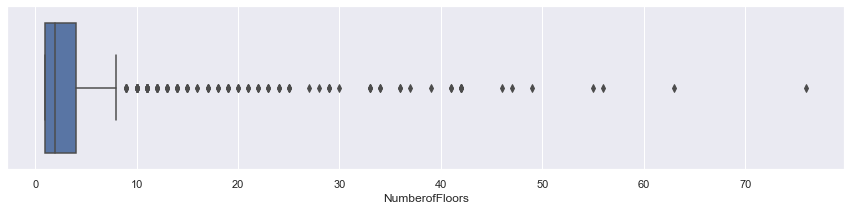

In [706]:
ax, fig = plt.subplots(figsize=(15,3)) 
sns.boxplot(x=df.NumberofFloors)

In [707]:
ratio_ten_plus = df.NumberofFloors[df.NumberofFloors > 10].count()/len(df)*100
print(f'{ratio_ten_plus:.2f}% of buildings have more than 10 floors')

6.73% of buildings have more than 10 floors


### 2.6.3 Ground surface inside buildings - PropertyGFABuilding

In [708]:
df['PropertyGFABuilding'].describe()

count    1.605000e+03
mean     1.059949e+05
std      2.872638e+05
min      1.092500e+04
25%      2.830400e+04
50%      4.680000e+04
75%      9.450000e+04
max      9.320156e+06
Name: PropertyGFABuilding, dtype: float64

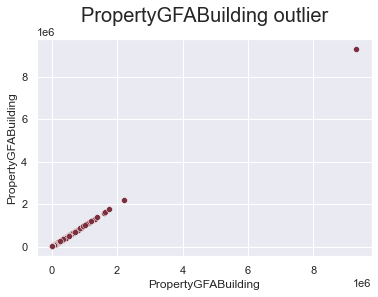

In [709]:
sns.scatterplot(x=df['PropertyGFABuilding'], y=df['PropertyGFABuilding'], color='#7B2E3E')
plt.title('PropertyGFABuilding outlier', fontsize=20, y=1.05)
plt.savefig("Outlier1.png", transparent=True, bbox_inches='tight')

<div class="alert alert-block alert-info">

One outlier is visible: surface is significantly higher than elsewhere.
    
</div>

In [710]:
df.reset_index(drop=True, inplace=True)

In [711]:
df['PropertyGFABuilding'].idxmax()

1568

In [712]:
max_surface = df.iloc[df['PropertyGFABuilding'].idxmax()]
max_surface

OSEBuildingID                 49967
PrimaryPropertyType      University
CouncilDistrictCode               4
Neighborhood              NORTHEAST
Latitude                   47.65644
Longitude                -122.31041
YearBuilt                      1900
NumberofBuildings      two_and_more
NumberofFloors                  1.0
PropertyGFATotal            9320156
PropertyGFABuilding         9320156
PropertyGFAParking                0
ENERGYSTARScore                 NaN
Energy                  873923712.0
Emissions                  11140.56
Name: 1568, dtype: object

In [713]:
df.drop(df['PropertyGFABuilding'].idxmax(), axis=0, inplace=True)

### 2.6.4 Ground surface inside parkings - PropertyGFAParking

In [714]:
df['PropertyGFAParking'].describe()

count      1604.000000
mean      13200.476309
std       42878.636873
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      512608.000000
Name: PropertyGFAParking, dtype: float64

<AxesSubplot:xlabel='PropertyGFAParking'>

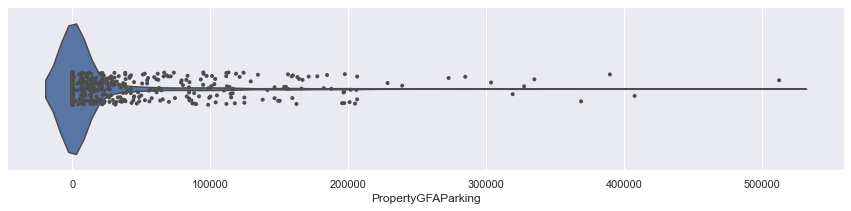

In [715]:
ax, fig = plt.subplots(figsize=(15,3)) 
sns.violinplot(x=df.PropertyGFAParking)
sns.stripplot(x=df.PropertyGFAParking, size=4, color=".3", linewidth=0)

### 2.6.5 Total ground surface inside and outside - PropertyGFATotal

In [716]:
df['PropertyGFATotal'].describe()

count    1.604000e+03
mean     1.134509e+05
std      1.941166e+05
min      1.128500e+04
25%      2.937000e+04
50%      4.887000e+04
75%      1.044605e+05
max      2.200000e+06
Name: PropertyGFATotal, dtype: float64

<AxesSubplot:xlabel='PropertyGFATotal'>

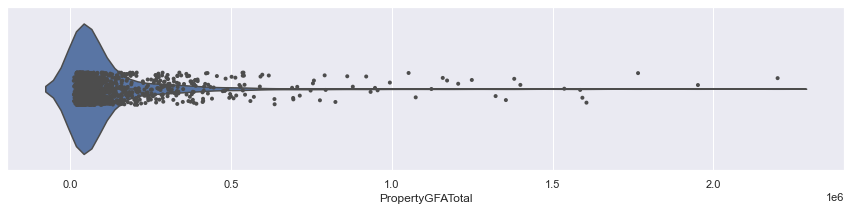

In [717]:
ax, fig = plt.subplots(figsize=(15,3)) 
sns.violinplot(x=df.PropertyGFATotal)
sns.stripplot(x=df.PropertyGFATotal, size=4, color=".3", linewidth=0)

### 2.6.6 Total building surface

<div class="alert alert-block alert-info">

Total surface inside each building can be obtained by multipying the ground surface by the number of floors.<br>
A new feature is created: 'TotalInnerSurface'.
    
</div>

In [718]:
df['TotalInnerSurface'] = df['NumberofFloors']*df['PropertyGFABuilding']

<AxesSubplot:xlabel='TotalInnerSurface', ylabel='Count'>

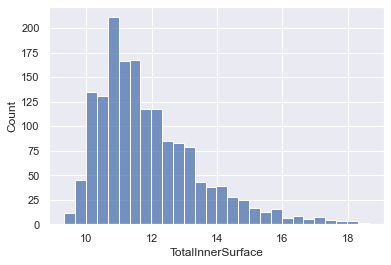

In [719]:
sns.histplot(df['TotalInnerSurface'].apply(lambda x : np.log(x+1)))

## <a name="C2.7">2.7 Construction date</a>

<AxesSubplot:xlabel='YearBuilt', ylabel='Count'>

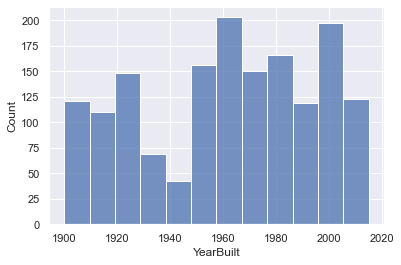

In [720]:
sns.histplot(df['YearBuilt'])

In [721]:
df['YearBuilt'].describe()

count    1604.000000
mean     1961.569825
std        32.761936
min      1900.000000
25%      1930.000000
50%      1965.000000
75%      1989.000000
max      2015.000000
Name: YearBuilt, dtype: float64

<div class="alert alert-block alert-info">

Year of construction is binned into decades.
    
</div>

In [722]:
bins = np.arange(1899, 2029, 10).tolist()
names = [str(int(x)) for x in np.linspace(1900, 2010, 12)]

df['YearBuilt'] = pd.cut(df['YearBuilt'], bins, labels=names)

In [723]:
df['YearBuilt'].value_counts()

1960    219
2000    194
1920    166
1980    163
1950    160
1970    160
1990    144
1900    121
1910    110
1940     63
1930     53
2010     51
Name: YearBuilt, dtype: int64

<AxesSubplot:xlabel='YearBuilt', ylabel='Count'>

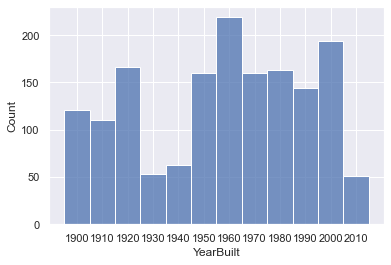

In [724]:
sns.histplot(df['YearBuilt'])

## <a name="C2.8">2.8 Energy star score</a>

<AxesSubplot:xlabel='ENERGYSTARScore', ylabel='Count'>

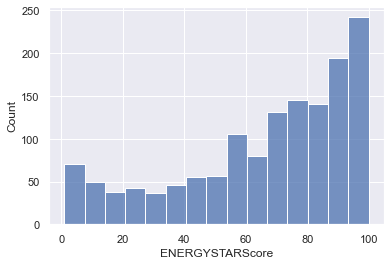

In [725]:
sns.histplot(df['ENERGYSTARScore'])

In [726]:
df['ENERGYSTARScore'].describe()

count    1434.000000
mean       66.112971
std        28.273459
min         1.000000
25%        50.000000
50%        74.000000
75%        89.000000
max       100.000000
Name: ENERGYSTARScore, dtype: float64

## <a name="C2.9">2.9 Verifying columns types and missing values</a>

In [727]:
df.dtypes

OSEBuildingID             int64
PrimaryPropertyType      object
CouncilDistrictCode      object
Neighborhood             object
Latitude                float64
Longitude               float64
YearBuilt              category
NumberofBuildings      category
NumberofFloors          float64
PropertyGFATotal          int64
PropertyGFABuilding       int64
PropertyGFAParking        int64
ENERGYSTARScore         float64
Energy                  float64
Emissions               float64
TotalInnerSurface       float64
dtype: object

<div class="alert alert-block alert-info">

Type of each column is acceptable.    
</div>

In [728]:
df[i].isna().sum()

0

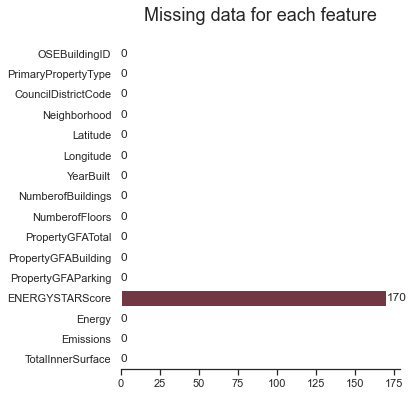

In [729]:
missing = df.isna().sum()#.mean()#.sort_values()
sns.set_style("white")
sns.set_style("ticks")

plt.figure(figsize=(5, 6))
ax = sns.barplot(y=missing.index,
                 x=missing.values, color='#7B2E3E')

container = ax.containers[0]
ax.bar_label(container,
             labels=[f'{x:.0f}' for x in container.datavalues])
#ax.spines['top'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(left=False)
# ax.xaxis.tick_top()
plt.title('Missing data for each feature', fontsize=18, y=1.05)
plt.savefig('missing_after_cleaning.png', transparent=True, bbox_inches='tight')
ax
plt.show()

<div class="alert alert-block alert-info">

Only 'ENERGYSTARScore' is incomplete.
    
</div>

# <a name="C3">3. Exploratory data analysis</a>

## <a name="C3.1">3.1 Univariate analysis</a>

<div class="alert alert-block alert-info">

Variables can be separated into qualitative and quantitative:<br><br>
   
<ins>**Quantitative variables**</ins><br><br>
    <li>Latitude</li>
    <li>Longitude</li>
    <li>PropertyGFABuilding</li>
    <li>PropertyGFAParking</li>
    <li>PropertyGFATotal</li>
    <li>TotalInnerSurface</li>
    <li>NumberofFloors</li>
    <li>ENERGYSTARScore</li>
    <li>**Energy**</li>
    <li>**Emissions**</li><br>

<ins>**Qualitative variables**</ins><br><br>
    <li>CouncilDistrictCode</li>
    <li>Neighborhood</li>
    <li>PrimaryPropertyType</li>
    <li>NumberofBuildings</li>
    <li>YearBuilt</li>    
 
</div>

In [730]:
quant = df.loc[:, df.columns != 'OSEBuildingID'].select_dtypes(exclude=['object','category']).columns
qual = df.loc[:, df.columns != 'OSEBuildingID'].select_dtypes(exclude=['int', 'float']).columns

In [731]:
quant

Index(['Latitude', 'Longitude', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFABuilding', 'PropertyGFAParking', 'ENERGYSTARScore',
       'Energy', 'Emissions', 'TotalInnerSurface'],
      dtype='object')

In [732]:
qual

Index(['PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood',
       'YearBuilt', 'NumberofBuildings'],
      dtype='object')

### 3.1.1 Quantitative variables

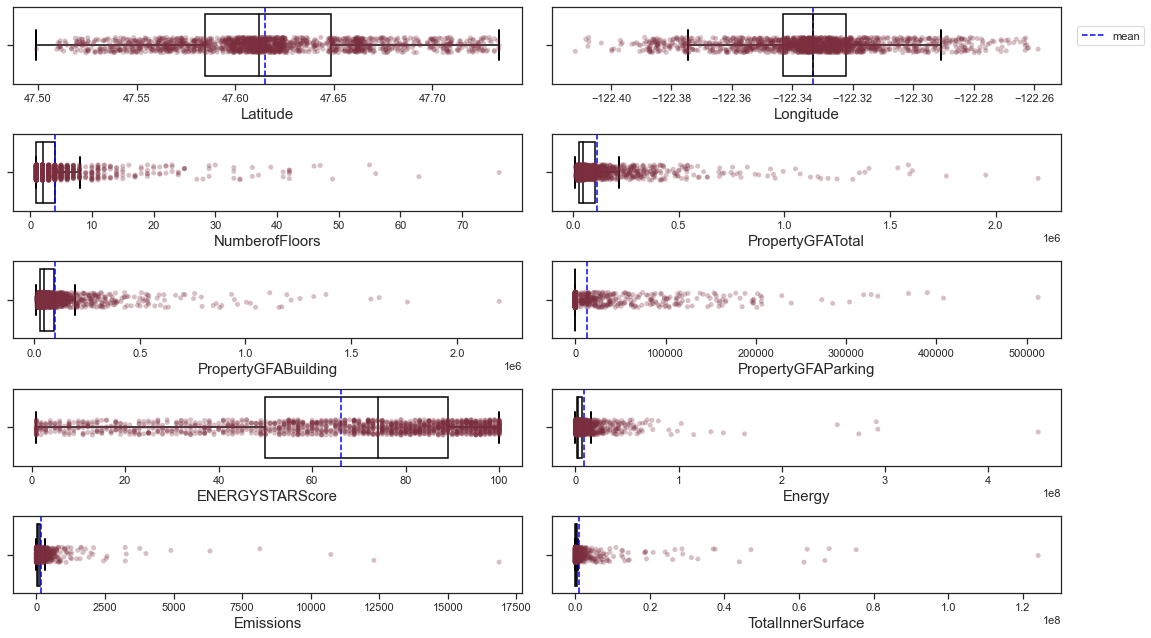

In [733]:
fig = plt.figure(figsize=(15, 14))
fig.suptitle('', fontsize=20, y=1.00) #Quantitative variables distribution
for i, label in enumerate(quant) :
    plt.subplot(8, 2, i+1)
    
    box = sns.boxplot(x=df[label], color='white', showfliers=False,
               boxprops = dict(linestyle='-', edgecolor='black'),
               medianprops = dict(linestyle='-', color='black'),
               whiskerprops = dict(linestyle='-', color='black'),
               capprops = dict(linestyle='-',linewidth=2.0, color='black')
               )
    sns.stripplot(x=df[label], color='#7B2E3E', alpha=0.3)
    plt.axvline(df[label].mean(), color='blue', ls='--', label='mean' if i == 0 else '')
    plt.xlabel(label, fontsize=15)
    
fig.legend(bbox_to_anchor=(1.07,0.96))
plt.tight_layout()
plt.savefig('Numerical_boxplot.png', transparent=True, bbox_inches='tight')
plt.show()

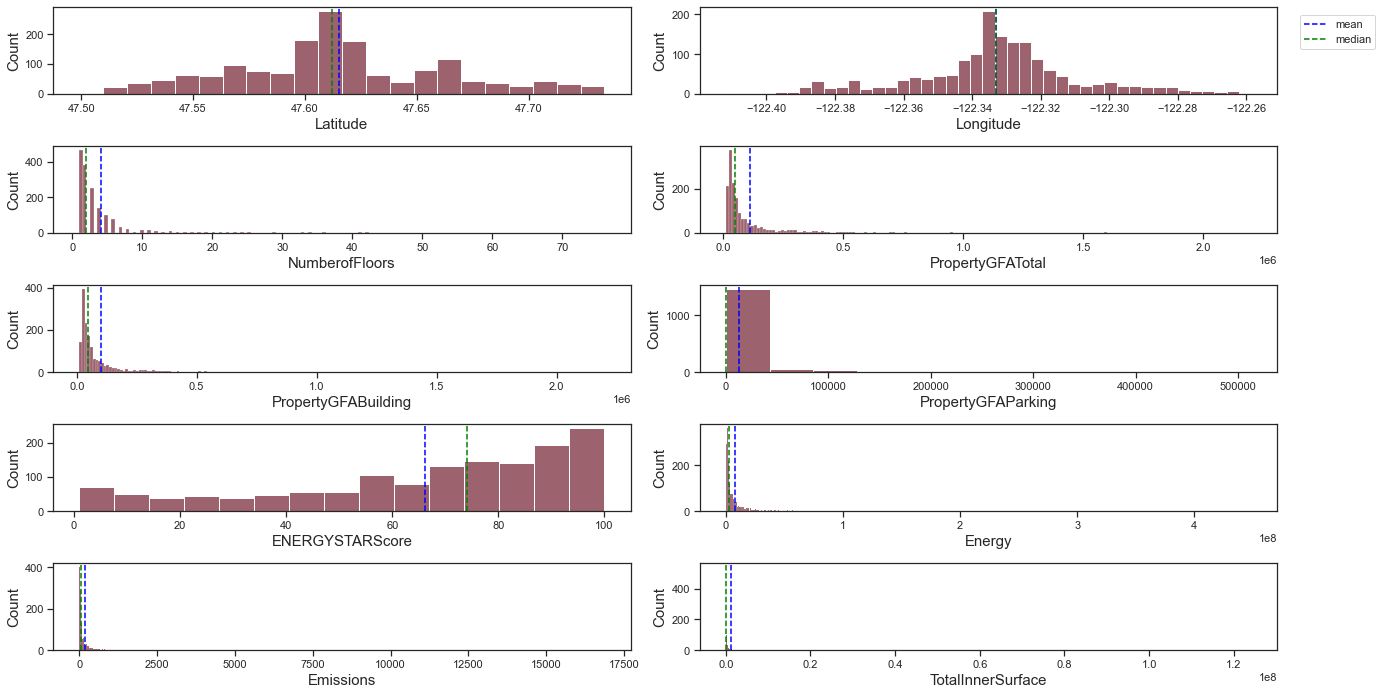

In [734]:
fig = plt.figure(figsize=(18, 10))
fig.suptitle('', fontsize=20, y=1.05)
for i, label in enumerate(quant) :
    plt.subplot(5, 2, i+1)
    sns.histplot(x=df[label], color='#7B2E3E')
    plt.axvline(df[label].mean(), color='blue', ls='--', label='mean' if i == 0 else '')
    plt.axvline(df[label].median(), color='green', ls='--', label='median' if i == 0 else '')
    plt.xlabel(label, fontsize=15)
    plt.ylabel('Count', fontsize=15)
fig.legend(bbox_to_anchor=(1.07,0.96))
plt.tight_layout()
plt.savefig('Histplot1.png', transparent=True, bbox_inches='tight')
plt.show()

In [735]:
skewed_group = quant[~quant.isin(['Latitude', 'Longitude', 'ENERGYSTARScore'])]

# residential = ['Residence Hall','Senior Ca = dict(linestyle='-',linewidth=3.0, color='black')re Community','Low-Rise Multifamily']
# df = df[~df['PrimaryPropertyType'].isin(residential)]

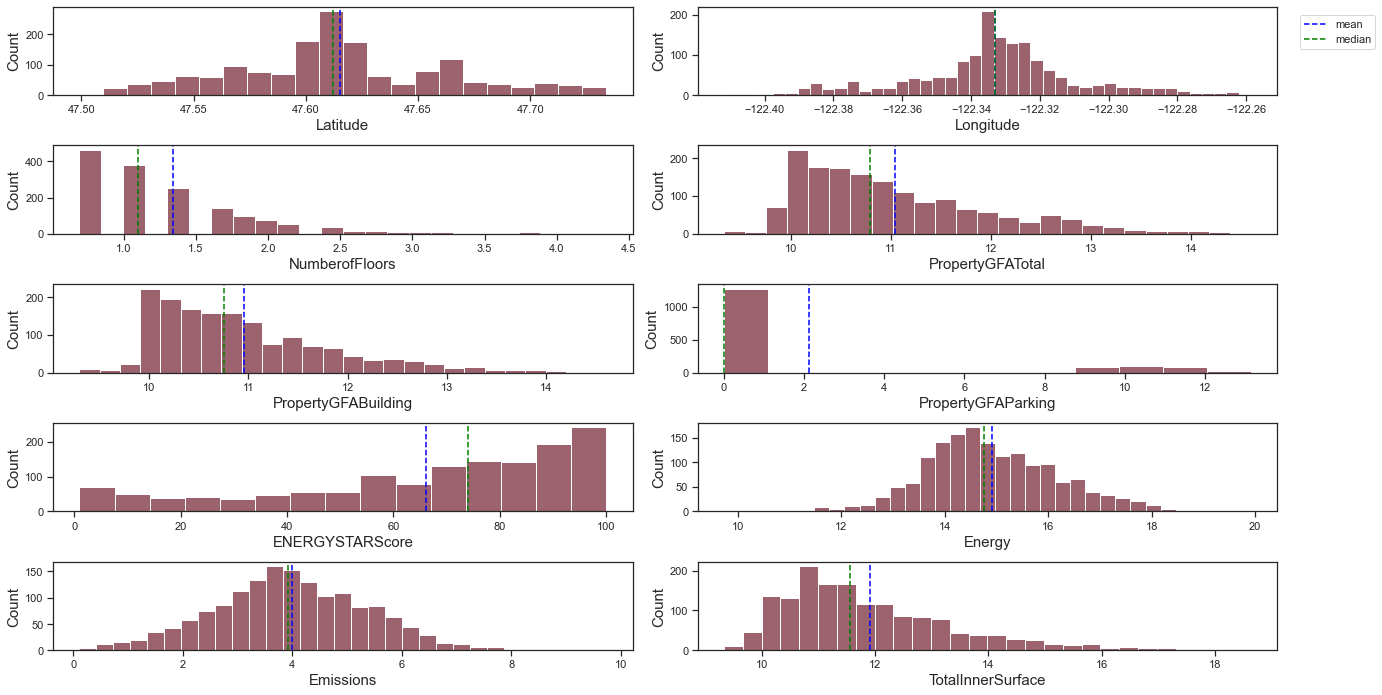

In [736]:
fig = plt.figure(figsize=(18, 10))
fig.suptitle('', fontsize=20, y=1.05)
for i, label in enumerate(quant) :
    plt.subplot(5, 2, i+1)
    if label in skewed_group:
        log_feature = df[label].apply(lambda x : np.log(x+1))
    else:
        log_feature = df[label]
    sns.histplot(log_feature, color='#7B2E3E')
    plt.axvline(log_feature.mean(), color='blue', ls='--', label='mean' if i == 0 else '')
    plt.axvline(log_feature.median(), color='green', ls='--', label='median' if i == 0 else '')
    plt.xlabel(label, fontsize=15)
    plt.ylabel('Count', fontsize=15)
fig.legend(bbox_to_anchor=(1.07,0.96))
plt.tight_layout()
plt.savefig('Histplot2.png', transparent=True, bbox_inches='tight')
plt.show()

### 3.1.2 Qualitative variables

In [737]:
def countplot(i, title, xdim=10, ydim=6):
    fig, ax = plt.subplots(figsize=(xdim,ydim))
    ax = sns.countplot(data=df, y=i, color='#7B2E3E')
    
    container = ax.containers[0]
    df_len = len(df[i])
    ax.bar_label(container,
             labels=[f'{x/df_len*100:.1f}%' for x in container.datavalues],
             label_type='center',
             size=15,
             color='white'
                )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.grid(axis='x', color='black', ls=':')
    
    plt.title(title, fontsize=20, y=1.02)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Count', fontsize = 15)
    plt.ylabel(f'{i}', fontsize = 15)
    plt.tight_layout()
    plt.savefig(f'countplot_{i}.png', transparent=True, bbox_inches='tight')
    return plt.show()

In [743]:
def countplot_ordered(i, title, xdim=10, ydim=6):
    fig, ax = plt.subplots(figsize=(xdim,ydim))
    ax = sns.countplot(data=df, y=i, color='#7B2E3E',
                  order=df[i].value_counts().index)
    
    container = ax.containers[0]
    df_len = len(df[i])
    ax.bar_label(container,
             labels=[f'{x/df_len*100:.1f}%' for x in container.datavalues],
             label_type='center',
             size=15,
             color='white'
                )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.grid(axis='x', color='black', ls=':')
    
    plt.title(title, fontsize=20, y=1.02)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Count', fontsize = 15)
    plt.ylabel(f'{i}', fontsize = 15)
    plt.tight_layout()
    plt.savefig(f'countplot_{i}.png', transparent=True, bbox_inches='tight')
    return plt.show()

In [744]:
import matplotlib.patheffects as patheffects
def donutplot(i, title, xdim=10, ydim=6, colors=sns.color_palette()):
    pie, ax = plt.subplots(figsize=[xdim,ydim])
#     sns.set_palette(sns.color_palette(colors))
    sizes = df[i].value_counts().sort_index() / df[i].value_counts().sum() * 100
 
#     textprops = {'fontsize': 16, 'fontname':'Helvetica',
#                            'color':'black'}

    wedges, labels, autopct = plt.pie(sizes,
                labels=sizes.index,
                autopct='%.0f%%',
                textprops={'fontsize': 16, 'fontname':'Helvetica',
                           'color':'black'},
                startangle=120,
                labeldistance=1.1,
                pctdistance=0.75,
                radius=1,
                wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white'},
                colors=colors
                )
    
#     textprops.set_path_effects([patheffects.withStroke(linewidth=5, foreground='w')])
    
    
    plt.axis('equal')
    plt.title(title, fontsize=25, loc='center', **{'fontname':'Helvetica'})
    plt.setp(labels, fontsize=20)

    # Ajout d'un cercle pour faire un donut
    my_circle=plt.Circle((0,0), 0.5, color='white')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.tight_layout()
    #plt.savefig("categories.png", transparent=True, bbox_inches='tight')
    plt.savefig(f'donutplot_{i}.png', transparent=True, bbox_inches='tight')
    return plt.show()





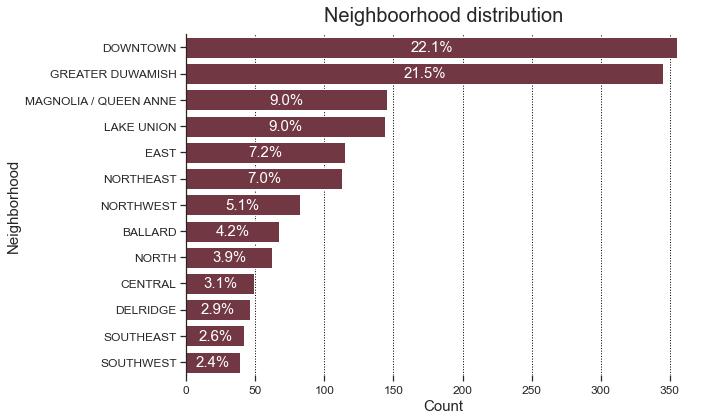

In [745]:
countplot_ordered('Neighborhood', 'Neighboorhood distribution', xdim=10, ydim=6)

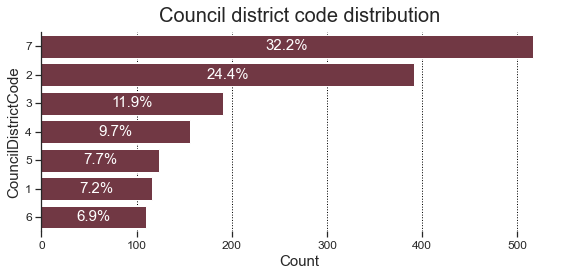

In [746]:
countplot_ordered('CouncilDistrictCode', 'Council district code distribution', 8, 4)

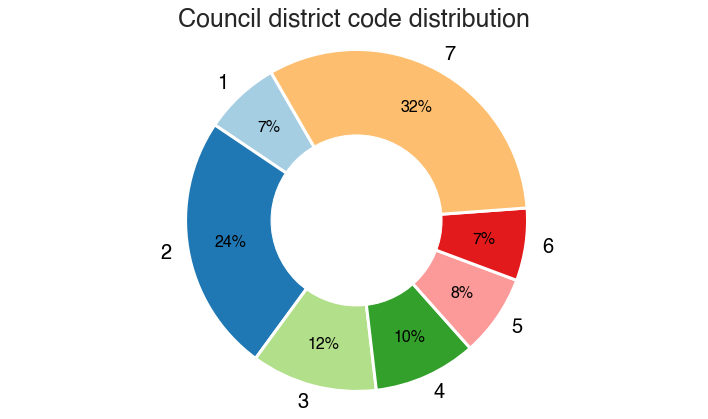

In [747]:
donutplot('CouncilDistrictCode', 'Council district code distribution', 10, 6, sns.color_palette('Paired'))

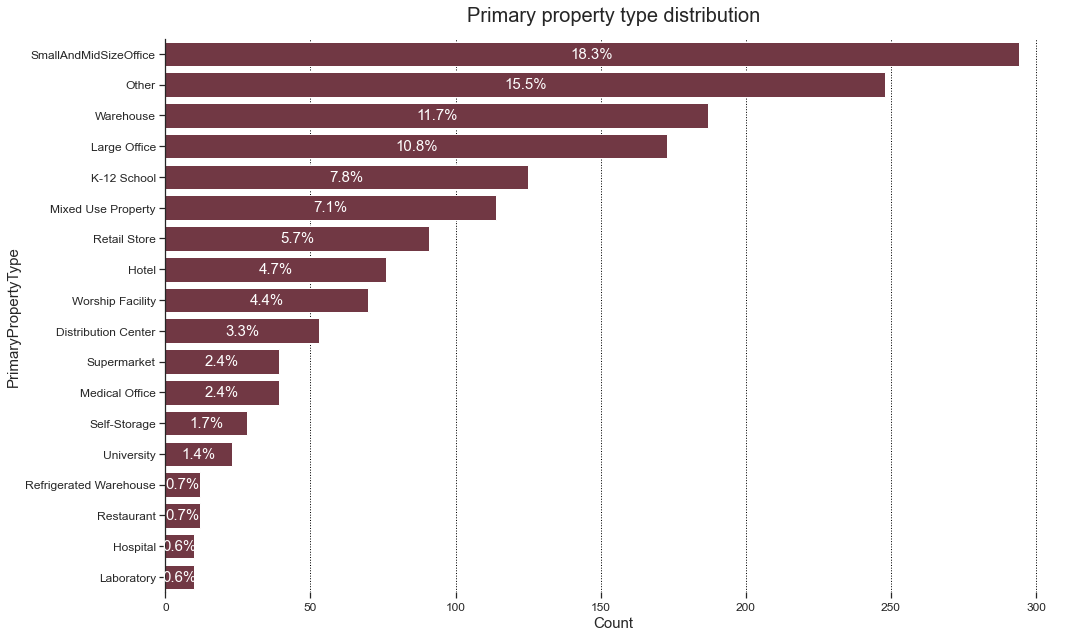

In [748]:
countplot_ordered('PrimaryPropertyType','Primary property type distribution', 15, 9)

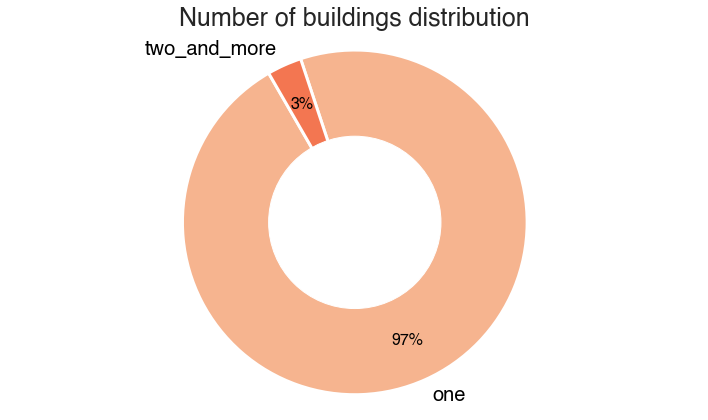

In [749]:
donutplot('NumberofBuildings', 'Number of buildings distribution', 10, 6, sns.color_palette('rocket_r'))

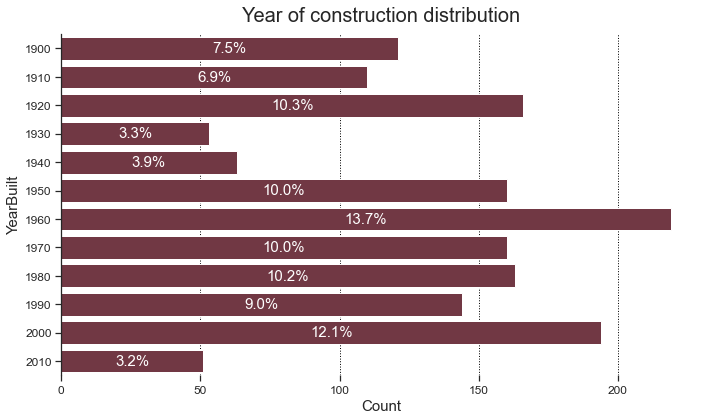

In [750]:
countplot('YearBuilt', 'Year of construction distribution')

## <a name="C3.2">3.2 Multivariate analysis</a>

### 3.2.1 Correlation matrix

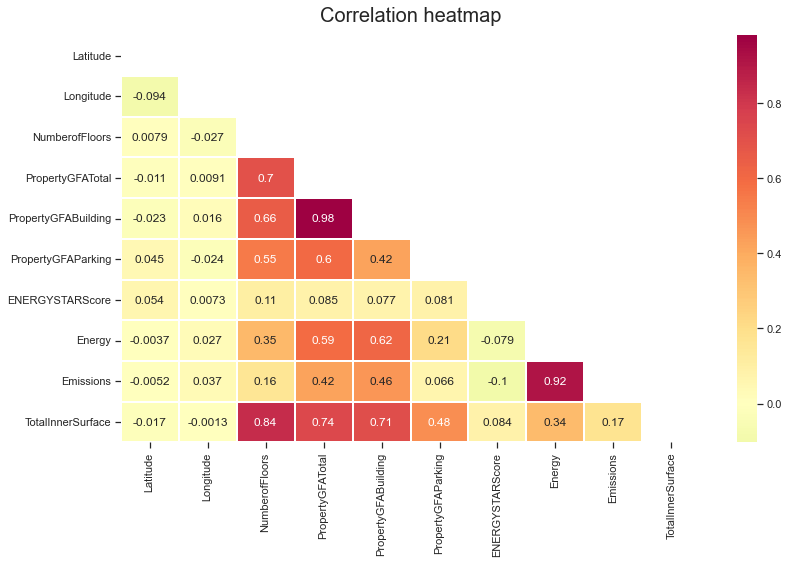

In [751]:
plt.subplots(figsize=(12, 8))
corr = df.loc[:, df.columns != 'OSEBuildingID'].corr()  

ax = sns.heatmap(corr,
                 annot=True,
                 cmap="Spectral_r",
                 center=0,
                 linewidths=2,
                 mask = np.triu(corr))
ax.set_title('Correlation heatmap', y=1.02, fontsize=20)
plt.tight_layout()
plt.savefig('Correlation_heatmap.png', transparent=True, bbox_inches='tight')
plt.show()

### 3.2.2 Scatter plots

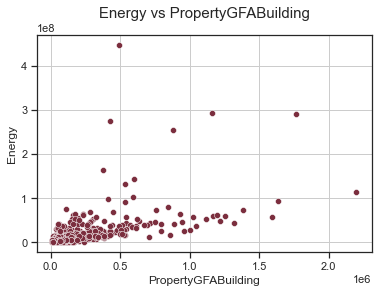

In [752]:
sns.scatterplot(x=df['PropertyGFABuilding'], y=df['Energy'], color='#7B2E3E')
plt.title('Energy vs PropertyGFABuilding', fontsize=15, y=1.05)
plt.grid()
plt.savefig('energy_vs_propertygfabuilding.png', transparent=True, bbox_inches='tight')

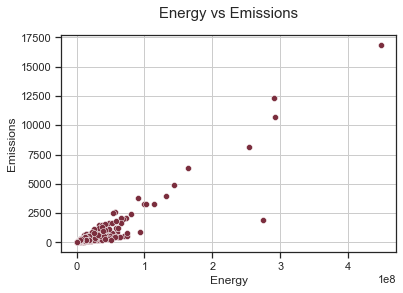

In [753]:
sns.scatterplot(x=df['Energy'], y=df['Emissions'], color='#7B2E3E')
plt.title('Energy vs Emissions', fontsize=15, y=1.05)
plt.grid()
plt.savefig('energy_vs_emissions.png', transparent=True, bbox_inches='tight')

### 3.2.3 PCA

In [754]:
# Number of components
n_comp = 6

# Features selection
data_pca = df[quant].loc[:, df[quant].columns != 'ENERGYSTARScore']

# Prepare data for PCA
# data_pca = data_pca.fillna(data_pca.mean())
X_pca = data_pca.values
names = data_pca.index # or data.index to get labels
features = data_pca.columns

# Standardize features by removing the mean and scaling to unit variance
std_scale = preprocessing.StandardScaler().fit(X_pca)
X_scaled = std_scale.transform(X_pca)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=6)

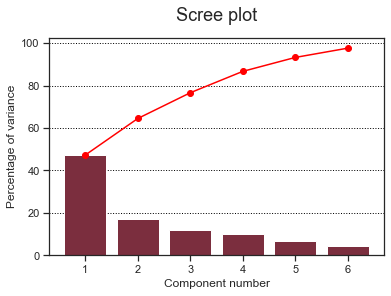

In [755]:
# Scree plot of eigenvalues

def display_scree_plot2(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree, color='#7B2E3E')
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c='red',marker='o')
    plt.xlabel('Component number', fontsize=12)
    plt.ylabel('Percentage of variance', fontsize=12)
    plt.grid(axis='y', color='black', ls=':')
    plt.title('Scree plot', fontsize=18, y=1.05)
    plt.savefig('scree_plot.png', transparent=True, bbox_inches='tight')
    plt.show(block=False)
    
display_scree_plot2(pca)

In [756]:
# Correlation circle

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # First 3 factorial planes are displayed, i.e. first 6 components
        if d2 < n_comp:

            fig, ax = plt.subplots(figsize=(6,6))

            # Diagram limits
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Showing arrows
            # If more than 30 arrows, tip is not shown
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="red", width=0.005)
                # (doc : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # Displaying variables labels 
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='left', va='bottom', rotation=label_rotation, color="black", alpha=0.5)
            
            # Displaying circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='black')
            plt.gca().add_artist(circle)

            # Diagram limits
            plt.xlim(xmin-0.01, xmax+0.01)
            plt.ylim(ymin-0.01, ymax+0.01)
        
            # Horizontal and vertical lines display
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Axes names, where percentage of variance is explained
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)), fontsize=14)
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)), fontsize=14)

            plt.title('Correlation circle for F{} and F{}'.format(d1+1, d2+1), fontsize=18, y=1.05)
            plt.savefig('Correlation_circle_F{}_and_F{}'.format(d1+1, d2+1), transparent=True, bbox_inches='tight')
            plt.show(block=False)

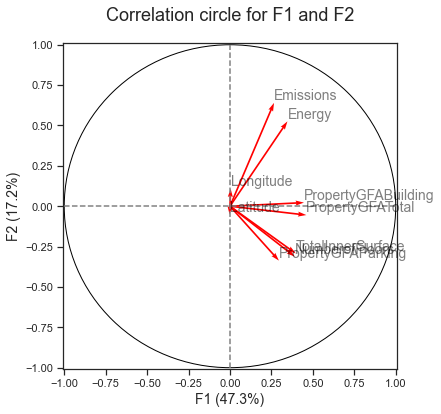

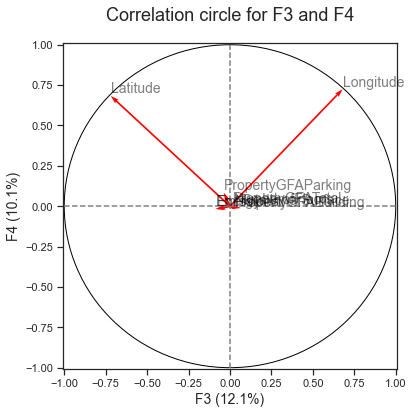

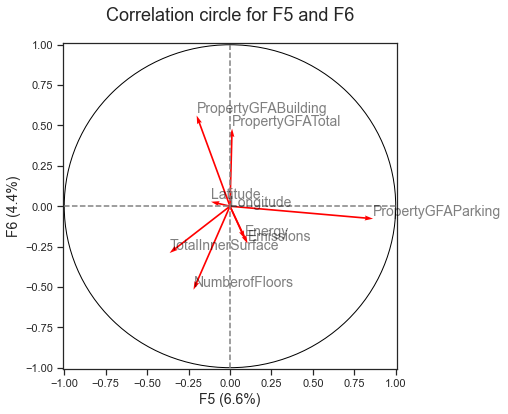

In [757]:
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

In [758]:
# Projection on factorial planes

def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:        
                 
            fig = plt.figure(figsize=(6,6))

            # Scatterplot
#             palette = {'a':'#449B57', 'b':'#92BB47', 'c':'#F6CE46', 'd':'#E08831', 'e':'#D54B26'}
            sns.scatterplot(x=X_projected[:, d1], y=X_projected[:, d2], alpha=alpha, 
                            hue=df.Energy
#                             palette='tab10',
#                             hue_order=['a','b','c','d','e']
                           )
#             plt.legend(bbox_to_anchor=(1.05, 0.5), loc=6, borderaxespad=0.)

            # Points label
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Diagram limits
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Horizontal and vertical lines display
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Axes names, where percentage of variance is explained
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)), fontsize=14)
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)), fontsize=14)

            plt.title('Projection of points on F{} and F{}'.format(d1+1, d2+1), fontsize=18, y=1.05)
            plt.savefig('Projection_of_points_on_F{}_and_F{}'.format(d1+1, d2+1), transparent=True, bbox_inches='tight')
            plt.show(block=False)


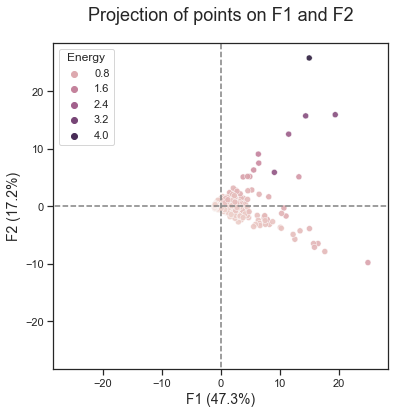

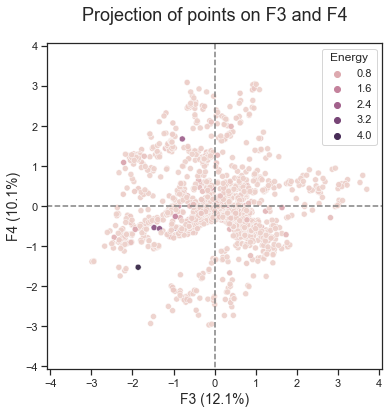

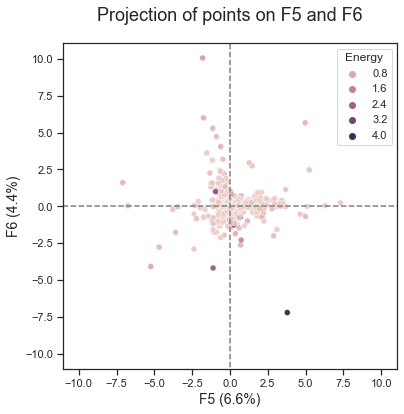

In [759]:
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], alpha=0.9)

# plt.show()

### 3.2.4 Box plots and ANOVA

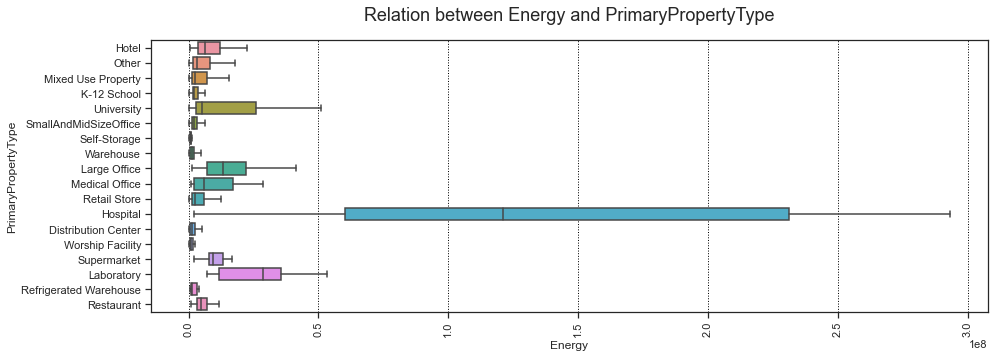

In [760]:
fig = plt.figure(figsize=(15,5))
sns.boxplot(x=df['Energy'], y=df['PrimaryPropertyType'], showfliers=False)
plt.xticks(rotation=90)
plt.grid(axis='x', color='black', ls=':')
plt.title('Relation between Energy and PrimaryPropertyType', fontsize=18, y=1.05)
plt.savefig('Boxplot_primarypropertytype_energy', transparent=True, bbox_inches='tight')
plt.show()

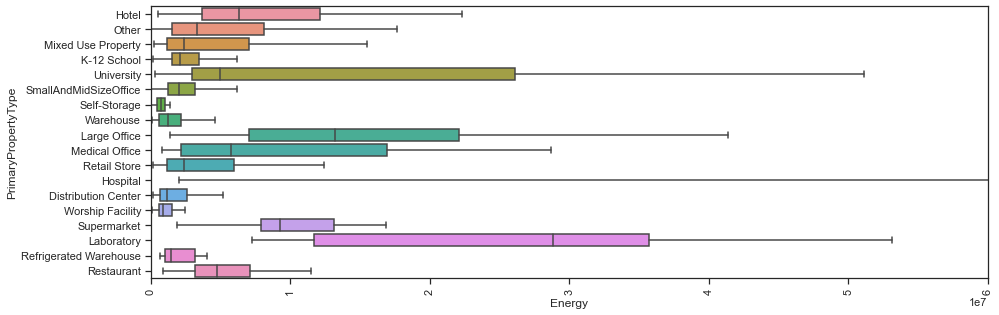

In [761]:
fig = plt.figure(figsize=(15,5))
sns.boxplot(x=df['Energy'] , y=df['PrimaryPropertyType'], showfliers=False)
plt.xticks(rotation=90)
plt.xlim(xmin=0,xmax=6e7)
plt.show()

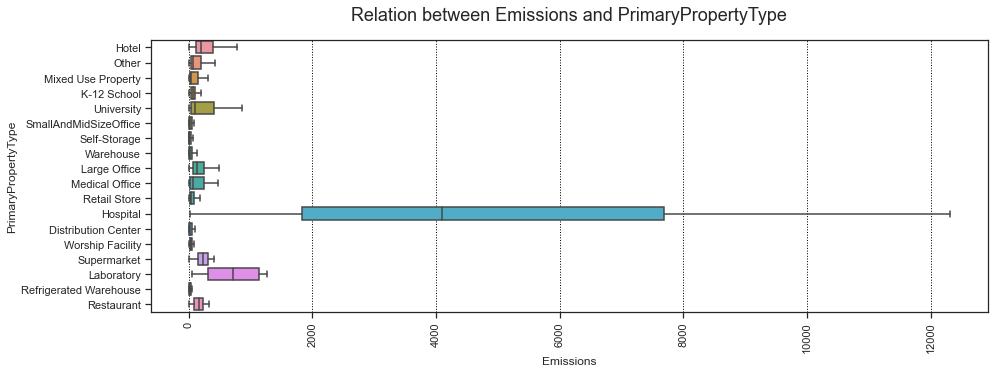

In [762]:
fig = plt.figure(figsize=(15,5))
sns.boxplot(x=df['Emissions'] , y=df['PrimaryPropertyType'], showfliers=False)
plt.xticks(rotation=90)
plt.grid(axis='x', color='black', ls=':')
plt.title('Relation between Emissions and PrimaryPropertyType', fontsize=18, y=1.05)
plt.savefig('Boxplot_primarypropertytype_emissions', transparent=True, bbox_inches='tight')
plt.show()

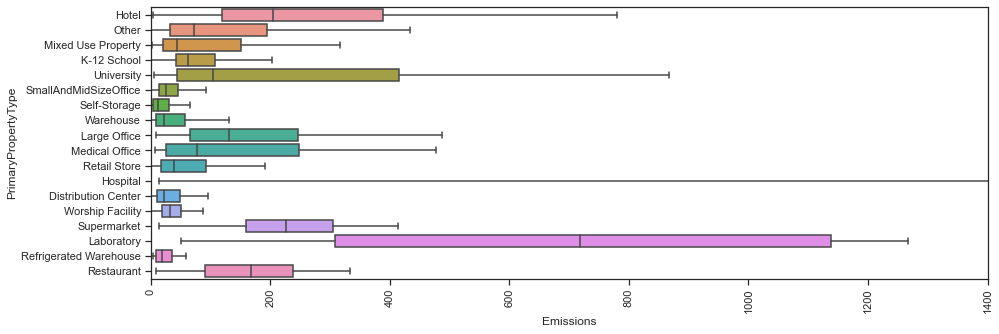

In [763]:
fig = plt.figure(figsize=(15,5))
sns.boxplot(x=df['Emissions'] , y=df['PrimaryPropertyType'], showfliers=False)
plt.xticks(rotation=90)
plt.xlim(xmin=0,xmax=1.4e3)
plt.show()

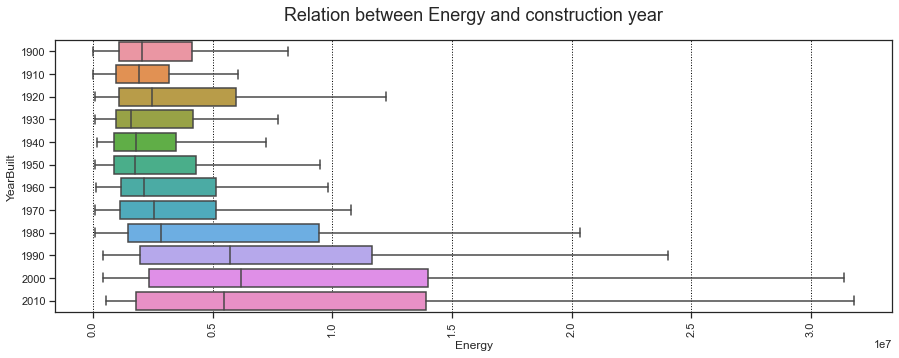

In [764]:
fig = plt.figure(figsize=(15,5))
sns.boxplot(x=df['Energy'] , y=df['YearBuilt'], showfliers=False)
plt.xticks(rotation=90)
plt.grid(axis='x', color='black', ls=':')
plt.title('Relation between Energy and construction year', fontsize=18, y=1.05)
plt.savefig('Boxplot_year_energy', transparent=True, bbox_inches='tight')
plt.show()

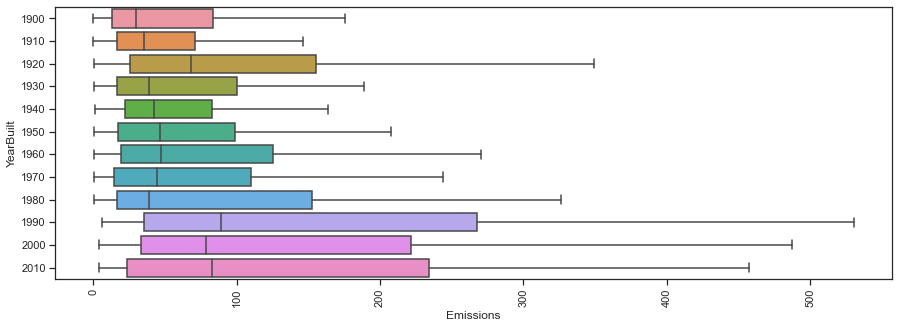

In [765]:
fig = plt.figure(figsize=(15,5))
sns.boxplot(x=df['Emissions'] , y=df['YearBuilt'], showfliers=False)
plt.xticks(rotation=90)
plt.show()

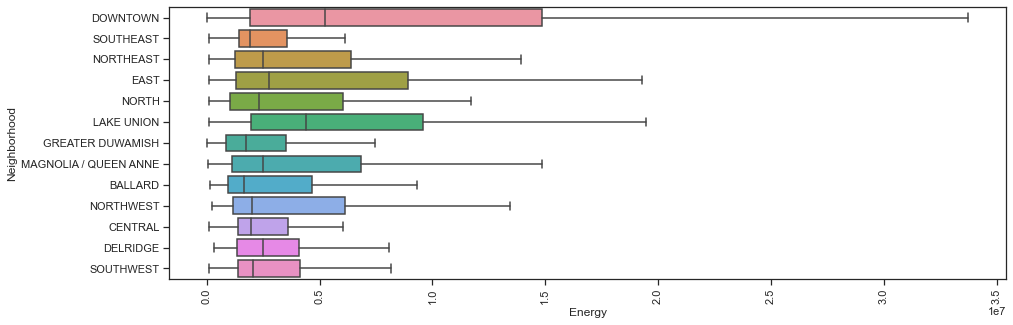

In [766]:
fig = plt.figure(figsize=(15,5))
sns.boxplot(x=df['Energy'] , y=df['Neighborhood'], showfliers=False)
plt.xticks(rotation=90)
plt.show()

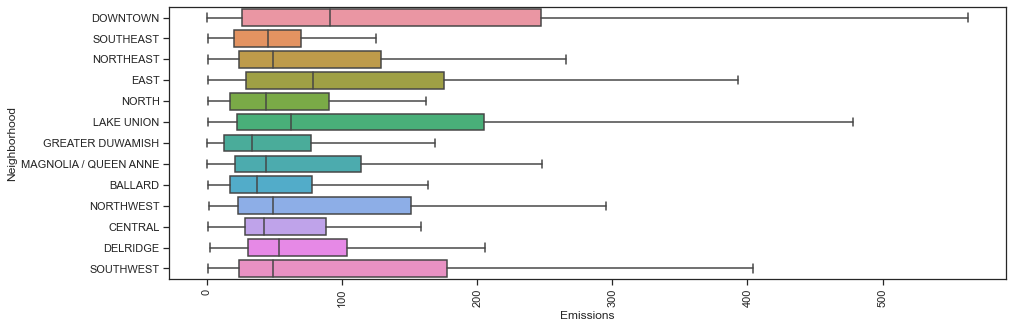

In [767]:
fig = plt.figure(figsize=(15,5))
sns.boxplot(x=df['Emissions'] , y=df['Neighborhood'], showfliers=False)
plt.xticks(rotation=90)
plt.show()

### ANOVA

In [786]:
def eta_squared(x, y):
    mean_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'class_mean': yi_classe.mean()})
    ESS = sum([c['ni']*(c['class_mean']-mean_y)**2 for c in classes]) #Explained Sum of Squares (ESS = SCE)
    TSS = sum([(yj-mean_y)**2 for yj in y]) #Total Sum of Squares (TSS = SST = SCT)
    return ESS/TSS

In [787]:
ANOVA_features = []
ANOVA_result = []


# StandardScale

df_anova = df[quant].loc[:, df[quant].columns != 'ENERGYSTARScore']

# scaler = StandardScaler()

# df.reset_index()
# df_scaled.reset_index()

# df_scaled = scaler.fit_transform(df_anova.to_numpy())
# df_scaled = pd.DataFrame(df_scaled, columns=list_features)

# df_scaled = df_scaled.reindex(df.index) 


k=0
for j in list(qual):
    ANOVA_result = []
    
    for i in list(df_anova.columns):
        ANOVA_features.append(i)
        ANOVA_result.append(eta_squared(df[j], df_anova[i]))
        
    if k==0:
        anova = pd.DataFrame(ANOVA_features, columns=['Numerical_features'])
    k+=1
        
    anova[j] = ANOVA_result
 
cm = sns.light_palette('#7B2E3E', as_cmap=True)
anova_styled = anova.style.background_gradient(cmap=cm, axis=None)
#https://pandas.pydata.org/docs/user_guide/style.html



dfi.export(anova_styled,'mytable.png')

[0412/190420.437083:INFO:headless_shell.cc(659)] Written to file /var/folders/sj/st52tvf971ngjhz8ft3l9_tr0000gn/T/tmpz07noz59/temp.png.


# <a name="C4">4. Exporting cleaned data</a>

In [ ]:
df.to_csv('cleaned.csv', index=False)